In [1]:
! git clone "https://github.com/AbdurRahman328/Dermnet.git"

Cloning into 'Dermnet'...
remote: Enumerating objects: 6536, done.
remote: Counting objects: 100% (3/3), done.
remote: Total 6536 (delta 0), reused 3 (delta 0), pack-reused 6533
Receiving objects: 100% (6536/6536), 591.22 MiB | 35.12 MiB/s, done.
Updating files: 100% (6900/6900), done.


In [2]:
import os
import cv2
from tqdm import tqdm
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [5]:
labels = ['Acne','Actinic','Atopic','Lupus']

X_train = []
y_train = []
image_size = 160
for i in labels:
    folderPath = os.path.join('/content/Dermnet/train/',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)



100%|██████████| 420/420 [00:02<00:00, 206.70it/s]


In [6]:
num_classes = len(labels)

In [7]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X_train,y_train,test_size = 0.2, random_state = 101)

In [8]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
categories = labels #['glioma_tumor','pituitary_tumor','no_tumor','meningioma_tumor']
le.fit(categories)
y_train = le.transform(y_train)
y_test = le.transform(y_test)

In [9]:

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from keras.utils import to_categorical


y_train1=np.array(y_train)
y_test1=np.array(y_test)

train_Y_one_hot = to_categorical(y_train1)
test_Y_one_hot = to_categorical(y_test)


# x_train2=np.zeros((len(x_train),160,160,3))
x_train2 = np.zeros((len(x_train),160,160,3),dtype='uint8')
for i in range(0,len(x_train)):
        x_train2[i,:,:,:]=x_train[i]

x_test2=np.zeros((len(x_test),160,160,3),dtype='uint8')
for i in range(0,len(x_test)):
        x_test2[i,:,:,:]=x_test[i]


In [10]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,BatchNormalization,Dropout
from tensorflow.keras.losses import CategoricalCrossentropy

In [11]:
def create_model():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(160, 160, 3))

    model = Sequential()
    model.add(base_model)
    model.add(Flatten())
    model.add(BatchNormalization())
    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))a
    model.add(Dense(num_classes, activation='softmax'))

    # Freeze the VGG16 layers
    for layer in base_model.layers:
        layer.trainable = False


    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model


In [ ]:
pip install dask

Note: you may need to restart the kernel to use updated packages.


In [12]:

 def load_data():

     y_train1=np.array(y_train)
     y_test1=np.array(y_test)

     train_Y_one_hot = to_categorical(y_train1)
     test_Y_one_hot = to_categorical(y_test)


     x_train2=np.zeros((len(x_train),160,160,3),dtype='uint8')
     for i in range(0,len(x_train)):
             x_train2[i,:,:,:]=x_train[i]

     x_test2=np.zeros((len(x_test),160,160,3),dtype='uint8')
     for i in range(0,len(x_test)):
             x_test2[i,:,:,:]=x_test[i]

     return x_train2, y_train1, x_test2, y_test1

# import dask.array as da
# from tensorflow.keras.utils import to_categorical

# def load_data():
#     y_train1 = da.from_array(np.array(y_train), chunks=(len(y_train),))
#     y_test1 = da.from_array(np.array(y_test), chunks=(len(y_test),))

#     train_Y_one_hot = da.from_array(to_categorical(y_train1), chunks=(len(y_train), num_classes))
#     test_Y_one_hot = da.from_array(to_categorical(y_test1), chunks=(len(y_test), num_classes))

#     x_train2 = da.from_array(np.zeros((len(x_train), 160, 160, 3)), chunks=(1, 160, 160, 3))
#     for i in range(len(x_train)):
#         x_train2[i,:,:,:] = da.from_array(x_train[i], chunks=(160, 160, 3))

#     x_test2 = da.from_array(np.zeros((len(x_test), 160, 160, 3)), chunks=(1, 160, 160, 3))
#     for i in range(len(x_test)):
#         x_test2[i,:,:,:] = da.from_array(x_test[i], chunks=(160, 160, 3))

#     return x_train2, y_train1, x_test2, y_test1

In [13]:
from keras.preprocessing.image import ImageDataGenerator

In [14]:
def federated_averaging(global_model, client_models):
    # Aggregate model weights
    average_weights = []
    for layer in range(len(global_model.get_weights())):
        layer_weights = tf.reduce_sum([client.get_weights()[layer] for client in client_models], axis=0)
        average_weights.append(layer_weights / len(client_models))
    global_model.set_weights(average_weights)

In [15]:
def federated_learning(num_clients=10, num_epochs=5):
    global_model = create_model()

    # Load and split data across clients
    x_train, y_train, x_test, y_test = load_data()
    client_data_size = len(x_train2) // num_clients

    client_models = [create_model() for _ in range(num_clients)]
    client_accuracies = []

    

    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    # Apply data augmentation to x_train2
    datagen.fit(x_train2)

    

    overall_history = {'loss': [], 'accuracy': []}



    # Evaluate client models on test data before training
    for client_id in range(num_clients):
        test_loss, test_acc = client_models[client_id].evaluate(x_test2, y_test1, verbose=0)
        client_accuracies.append(test_acc)
        print(f"Client {client_id + 1} (Before Training): Accuracy = {test_acc:.4f}")

    # Train client models locally
    for client_id in range(num_clients):
        start_idx = client_id * client_data_size
        end_idx = start_idx + client_data_size
        x_local, y_local = x_train2[start_idx:end_idx], y_train1[start_idx:end_idx]

        history = client_models[client_id].fit(x_local, y_local, epochs=num_epochs, verbose=1)

        # Evaluate client model on local test data
        test_loss, test_acc = client_models[client_id].evaluate(x_test2, y_test1, verbose=0)
        print(f"Client {client_id + 1}: Accuracy = {test_acc:.4f}, Loss = {test_loss:.4f}")


    # Print client accuracies
    print("Client Accuracies (Before Training):", client_accuracies)


    # Aggregate model updates using federated averaging
    federated_averaging(global_model, client_models)

    # Evaluate the global model on the test and train data
    test_loss, test_acc = global_model.evaluate(x_test2, y_test1)
    train_loss, train_acc = global_model.evaluate(x_train2, y_train1)
    return global_model



In [ ]:
global_model=federated_learning(num_clients=5,num_epochs=20)

19/19 [==============================] - 1s 65ms/step


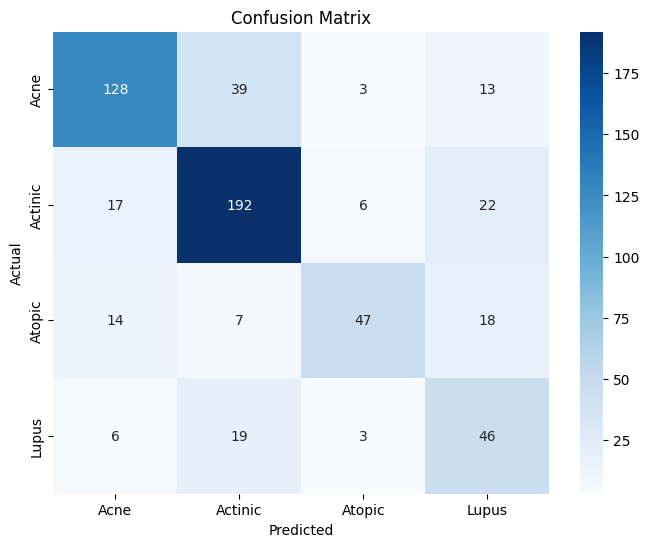

In [17]:
def generate_confusion_matrix(model, x_data, y_data, labels):
    # Predict labels
    predictions = model.predict(x_data)
    y_pred = np.argmax(predictions, axis=1)

    # Create confusion matrix
    cm = confusion_matrix(y_data, y_pred)

    # Plot the confusion matrix using seaborn
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Assuming 'global_model' is the model you want to evaluate
generate_confusion_matrix(global_model, x_test2, y_test1, labels)


In [18]:
from sklearn.metrics import classification_report

def evaluate_metrics(model, x_data, y_data, labels):
    # Predict labels
    predictions = model.predict(x_data)
    y_pred = np.argmax(predictions, axis=1)

    # Print classification report
    report = classification_report(y_data, y_pred, target_names=labels)
    print("Classification Report:\n", report)

# Assuming 'global_model' is the model you want to evaluate
evaluate_metrics(global_model, x_test2, y_test1, labels)


19/19 [==============================] - 1s 76ms/step
Classification Report:
               precision    recall  f1-score   support

        Acne       0.78      0.70      0.74       183
     Actinic       0.75      0.81      0.78       237
      Atopic       0.80      0.55      0.65        86
       Lupus       0.46      0.62      0.53        74

    accuracy                           0.71       580
   macro avg       0.70      0.67      0.67       580
weighted avg       0.73      0.71      0.71       580



19/19 [==============================] - 1s 66ms/step


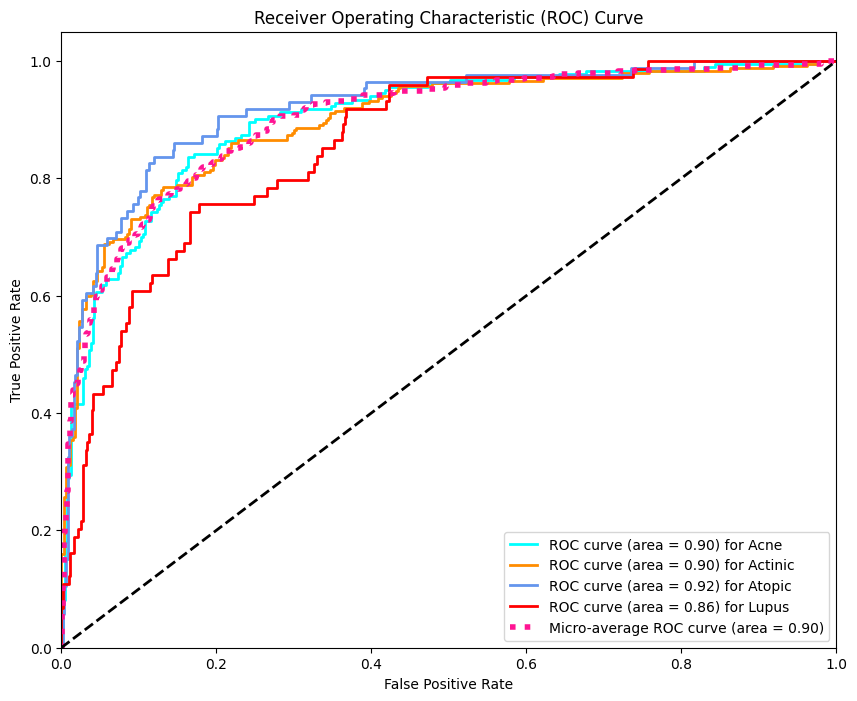

In [21]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

def plot_roc_curve(model, x_data, y_data, num_classes, class_labels):
    # Convert the labels to one-hot encoding
    y_data_one_hot = label_binarize(y_data, classes=range(num_classes))

    # Get predicted probabilities for each class
    y_score = model.predict(x_data)

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_data_one_hot[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_data_one_hot.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Plot ROC curves for each class
    plt.figure(figsize=(10, 8))
    lw = 2
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red'])

    for i, color in zip(range(num_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label=f'ROC curve (area = {roc_auc[i]:.2f}) for {class_labels[i]}')

    # Plot micro-average ROC curve
    plt.plot(fpr["micro"], tpr["micro"],
             label=f'Micro-average ROC curve (area = {roc_auc["micro"]:.2f})',
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

# Assuming 'global_model' is the model you want to evaluate
plot_roc_curve(global_model, x_test2, y_test1, num_classes=len(labels), class_labels=labels)


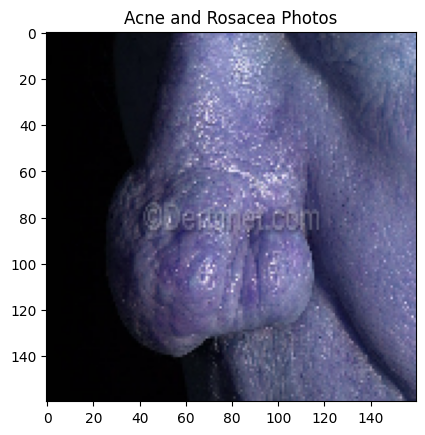


--------------------------------------
1/1 [==============================] - 0s 30ms/step
Actual Label: Acne and Rosacea Photos
Predicted value: Acne
--------------------------------------



In [20]:
import os

# ... (Previous code)

paths = ['/content/Dermnet/test/Acne and Rosacea Photos/07Rhinophyma1.jpg']

for i in paths:
    img = cv2.imread(i)

    # Check if the image is loaded successfully
    if img is not None:
        img = cv2.resize(img, (image_size, image_size))
        input_data = np.array(img)

        image_to_visualize = input_data

        # Display the image
        plt.imshow(image_to_visualize)
        plt.title(i.split('/')[-2])
        plt.show()

        input_single_image = np.expand_dims(input_data, axis=0)
        print()
        print("--------------------------------------")
        predicted = global_model.predict(input_single_image)
        print("Actual Label:", i.split('/')[-2])
        print("Predicted value:", labels[predicted.argmax()])
        print("--------------------------------------")
        print()
    else:
        print(f"Error loading image: {i}")
